<a href="https://colab.research.google.com/github/The7redarrow/ml-class/blob/master/Copy_of_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.9.0'

# Using word embeddings


## Meaning
For hundreds of years linguists have been investigating how to encode the semantic information of a word. Some belief that there is a universal mental concept, for example `MOON`, with some universal representation in our brains that gets represented in English as *moon* in Uyghur as ئاي, as *Hanhepi wi* in Lakota, and as 
月 in Japanese. It is also believed that  concepts such as `MOON` and `SUN` share some common semantic features. Similar words would cluster together in semantic space. For example, moon, sun, Mars, Neptune, the Milky Way Galaxy seem to have some similarities and form a group as does a group we could label domestic animals that might include horses, dogs, and cats, which in turn are different from wild animals. So words like *dog*, *cat*, *horse*, have, as part of their semantic meaning, some feature that is the same among these words  and that feature is not present in the representations for the words *moon* or *sun*. These semantic features impact how a word occurs in different contexts. 

For example, it would be rare for a verb to follow the word *the*:

* *The says ...
* *The haven't
* *The see

(Here the asterisk * represents a sentence most people would find odd). And again, this is just probability. Certainly, you can construct sentences that have these sequences that are perfectly fine (*The says who questioning method .*, *Just experimenting with the Says Who basics on myself on with clients*, *The haven't had time excuse*). But the likelihood of the word *says* following *the* is extremely rare. 

Similarly, sentences like

* I fed my ___
* I fed my dog
* I fed my poodle
* I fed my cat
* I fed my horse

occur much more frequently than

* I fed my ___
* I fed my moon
* I fed my sun
* I fed my Neptune
* I fed my Milky Way Galaxy.

So, we come to the quote by Firth:

> You shall know a word by the company it keeps

The idea is a simple one. If we find a bunch of words that can follow the sequence *I fed my* we can assume that they share some semantic feature. And, if we didn't know English we could still do this analysis. We wouldn't know that the feature is domestic animal but we would know that they share some feature, let's call it x29. This, as we talked about is a latent feature.

Now, without going into any detail whatsoever, we can imagine giving an algorithm a gigaword corpus and telling it to come up with 100 semantic features that explain the distribution of the words in the corpus. 

That is what **word embeddings** are in their simplist form. 


### Sparse vs. dense dimensions.
In our previous work with text, we determined the size of our vocabulary, say 10,000 words, and created a vector where each column represented a different word in the vocabulary. So let's say column 1 was *a* and 2 *the*, and 7,253 *computer* and so on. If we encode a sentence that starts *the computer*, the word *the* would be represented by a '1' in column 1 and zeroes in the other 9,999 columns. The word *computer* would have a '1' in column 7,253 and zeroes in the other 9,999. That is an awful lot of zeroes, and this vector is called **sparse**. This looks like the first image below, where the blue square represents a '1' and the black represents all zeroes. 



![word embeddings vs. one hot encoding](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/wordEmbeddings.png)

With word embeddings we determine a feature size, 100, 200, 300 dimensions, and then each word is represented by a vector with values between 0 and 1. This is shown in the dense diagram above where the different colors represent different fractional values. 

In the one-hot-encoding method, each word was represented by a sparse vector the size of the vocabulary and vectors of 10,000 or 20,000 entries are not uncommon. In contrast, in the word embedding method, each word is represented by a dense vector of only 100 or 300 values. Thus, in the word embedding approach information is packed into a much smaller vector. 

In addition, in the one-hot encoding method there were no relationships between words. For example, *poodle* might be word 9,712 and *dog* 1,797, and they were treated completely separately. In the word embedding approach, the similarities of *poodle* and *dog* are represented within the word embeddings. 


#### Once again for emphasis
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 


#### Note
The following notebook is a remix of one by Francis Cholet (see the end of the notebook for more information)


### Obtaining word embeddings
There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 



In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [2]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. So, for example, we may have a dataset of 10,000 tweets so that 10,000 is the `samples` and each sample consists of a sequence of integers representing the words in the tweet. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. 

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 20,000 most common words 
and cut the reviews after only 50 words. Our network will simply learn 50-dimensional embeddings for each of the 20,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [3]:
!wget http://zacharski.org/files/courses/cs419/imdb.zip
!unzip imdb.zip

--2022-12-05 03:44:03--  http://zacharski.org/files/courses/cs419/imdb.zip
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26559010 (25M) [application/zip]
Saving to: ‘imdb.zip’

imdb.zip            100%[===================>]  25.33M  49.5MB/s    in 0.5s    

2022-12-05 03:44:04 (49.5 MB/s) - ‘imdb.zip’ saved [26559010/26559010]

Archive:  imdb.zip
  inflating: imdb.csv                


In [4]:
import pandas as pd
data = pd.read_csv('imdb.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
data_text = data.review
data_label =data.sentiment
data_label =  data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data_label 

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

### Converting words to integers
The first step we will do is convert words represented as strings to integers

We will use the Keras Tokenizer and specify the size of the vocabulary.

* num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.


In [6]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 20000)
#build the word index
tokenizer.fit_on_texts(data_text)
# now convert the words to integers
data_sequences = tokenizer.texts_to_sequences(data_text)
data_sequences[0]

[27,
 4,
 1,
 79,
 2102,
 45,
 1072,
 12,
 100,
 147,
 39,
 307,
 3184,
 398,
 474,
 26,
 3195,
 33,
 23,
 203,
 14,
 11,
 6,
 621,
 48,
 596,
 16,
 68,
 7,
 7,
 1,
 86,
 148,
 12,
 3241,
 68,
 42,
 3184,
 13,
 92,
 5398,
 2,
 15115,
 134,
 4,
 570,
 60,
 268,
 8,
 203,
 36,
 1,
 661,
 139,
 1740,
 68,
 11,
 6,
 21,
 3,
 119,
 15,
 1,
 7888,
 2333,
 38,
 11469,
 11,
 119,
 2595,
 54,
 5911,
 16,
 5510,
 5,
 1479,
 376,
 38,
 570,
 92,
 6,
 3804,
 8,
 1,
 360,
 356,
 4,
 1,
 661,
 7,
 7,
 9,
 6,
 433,
 3184,
 14,
 12,
 6,
 1,
 11648,
 358,
 5,
 1,
 15701,
 6813,
 2538,
 1064,
 9,
 2711,
 1421,
 20,
 538,
 32,
 4636,
 2468,
 4,
 1,
 1208,
 117,
 29,
 1,
 7017,
 25,
 2970,
 11964,
 2,
 391,
 34,
 16740,
 6,
 21,
 299,
 20,
 1,
 4910,
 7364,
 538,
 6,
 344,
 5,
 106,
 8161,
 14813,
 5050,
 7889,
 2453,
 2,
 51,
 34,
 327,
 9106,
 7365,
 12486,
 2,
 8697,
 23,
 110,
 225,
 243,
 7,
 7,
 10,
 58,
 131,
 1,
 280,
 1324,
 4,
 1,
 119,
 6,
 693,
 5,
 1,
 192,
 12,
 9,
 269,
 117,
 79,
 276,
 58

Just for grins, let's convert an IMDB review back to text



In [7]:
tokenizer.sequences_to_texts([data_sequences[1]])

["a wonderful little production br br the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes sense of realism to the entire piece br br the actors are extremely well chosen michael sheen not only has got all the but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams' diary entries not only is it well worth the watching but it is a written and performed piece a masterful production about one of the great master's of comedy and his life br br the realism really comes home with the little things the fantasy of the guard which rather than use the traditional techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and and the sets particularly of their flat with every surface are terribly well done"]

### Recap.
We stated we wanted the vocabulary size to be 20,000. This means that if we have a sentence like *xenophobic manifestations moved online* and *xenophobic* was not among the 20,000 most frequent words in the corpus, our encoding of that sentence would skip that word. *xenophobic manifestations moved online* becomes *manifestations moved online*

Now let's do a bit more preprocessing and truncate each review after 50 words (if the review is shorter than 50 words we will pad it with blank words):

In [10]:
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 50


from keras import preprocessing


# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
from keras.utils import pad_sequences
data50 = pad_sequences(data_sequences, maxlen=maxlen)
data50[0]

array([  504,    20,   642,     2,    76,   243,    16,     9,    69,
        7598,   651,   710,  6904,   109,   662,    82,  1208, 19395,
         693,     5,    65,   574,     4,   920,  2021,    38,  1208,
         559,   147,  3184,    22,   200,   426,  3819,    16,    48,
           6,  3314,   805,  1603,    43,    22,    67,    76,     8,
        1228,    16,   125,  4103,   486], dtype=int32)

# Now let's divide the data into training and testing



In [12]:
from sklearn.model_selection import train_test_split
train50, test50, train_labels, test_labels = train_test_split(data50, data_label, test_size = 0.2, random_state=42)
test_labels

33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64

# Time to build the model

So far we have:

* a 10,000 word vocabulary
* each review is limited to 50 words

And we want to create a word embedding with 50 features.

(Those 50 are completely separate parameters) The 50 word limit is not related to the 50 features.)

Let's create a network with an embedding layer


In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

vocabulary_size = 20000
embedding_size = 50
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(vocabulary_size, embedding_size, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, embedding_size)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * embedding_size)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1000000   
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 1)                 2501      
                                                                 
Total params: 1,002,501
Trainable params: 1,002,501
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
history = model.fit(
      train50, train_labels,
      steps_per_epoch=100,
      epochs=10,
      validation_split=0.2,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 3s 18ms/step - loss: 0.6442 - acc: 0.6821 - val_loss: 0.5431 - val_acc: 0.7788
Epoch 2/10
100/100 [==============================] - 2s 16ms/step - loss: 0.4422 - acc: 0.8203 - val_loss: 0.4093 - val_acc: 0.8195
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - loss: 0.3350 - acc: 0.8649 - val_loss: 0.3786 - val_acc: 0.8325
Epoch 4/10
100/100 [==============================] - 2s 18ms/step - loss: 0.2790 - acc: 0.8898 - val_loss: 0.3703 - val_acc: 0.8334
Epoch 5/10
100/100 [==============================] - 2s 17ms/step - loss: 0.2364 - acc: 0.9123 - val_loss: 0.3715 - val_acc: 0.8359
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.1981 - acc: 0.9288 - val_loss: 0.3787 - val_acc: 0.8340
Epoch 7/10
100/100 [==============================] - 2s 18ms/step - loss: 0.1624 - acc: 0.9483 - val_loss: 0.3869 - val_acc: 0.8305
Epoch 8/10
100/100 [==============================] - 2s 17ms/step - 

We get to a validation accuracy of ~82%, which is pretty good considering that we only look at the first 50 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. 

## Using pre-trained word embeddings


Sometimes, we have so little training data available that we could never use the data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem we want to solve, we could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Finally, there is FastText, also developed by Mikolov at Facebook. While state of the art, it is also the most resource intensive scheme.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. 

## Summary so far,

We...

1. downloaded the text data which was in the form of a csv file
2. loaded the file into pandas.
3. divided the csv into the text columns and the labels columns
4. tokenized the text into sequences of integers
5. limited each text to 50 words
5. divided the sequences and labels into training and test data

So, for example, the first entry of our data was


In [15]:
train50[0]

array([    3,   111,    12,  1569,   472,    75,   221,     5,   327,
           2,  3498,    35,    23,    51,    71,  1890,  4808,    14,
           9,  1388,    11,    19,     6,     3,  3574,  2064,    16,
          61,     1,  2414,   469,   533,     2,     3,   171,  2643,
       19293,  2811,  1776,     5,   586,     9,    36,     1,  3933,
         454,   156,   206,   352,  3944], dtype=int32)

### Download the GloVe word embeddings


Head to https://nlp.stanford.edu/projects/glove/ (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). The downloading will take a bit of time, which might be an understatement. 

For convenience, I have made available a zip of the exact file we will need at http://zacharski.org/files/courses/cs419/glove.6B.100d.zip This is only 134MB


Next, un-zip it.

In [19]:
!wget http://zacharski.org/files/courses/cs419/glove.6B.100d.zip
!unzip glove.6B.100d.zip


--2022-12-05 03:47:08--  http://zacharski.org/files/courses/cs419/glove.6B.100d.zip
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134300573 (128M) [application/zip]
Saving to: ‘glove.6B.100d.zip’

glove.6B.100d.zip   100%[===================>] 128.08M  83.6MB/s    in 1.5s    

2022-12-05 03:47:09 (83.6 MB/s) - ‘glove.6B.100d.zip’ saved [134300573/134300573]

Archive:  glove.6B.100d.zip
  inflating: glove.6B.100d.txt       


### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [21]:
import numpy as np

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


So this embedding file has a vocabulary size of 400,000 words and each word is associated with a 100 element vector. Let's not use all 400,000, but restrict our vocabulary to our original 20,000 (`max_words`).

Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [22]:
embedding_dim = 100
max_words = 20000
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                160032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,160,065
Trainable params: 2,160,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [24]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [25]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train50, train_labels,
                    epochs=10,
                    batch_size=32,
                     validation_split=0.2,
      validation_steps=50)
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
1000/1000 [==============================] - 7s 6ms/step - loss: 0.6197 - acc: 0.6532 - val_loss: 0.5715 - val_acc: 0.7056
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5459 - acc: 0.7244 - val_loss: 0.5489 - val_acc: 0.7163
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5212 - acc: 0.7404 - val_loss: 0.5457 - val_acc: 0.7306
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5000 - acc: 0.7550 - val_loss: 0.5624 - val_acc: 0.7138
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4766 - acc: 0.7696 - val_loss: 0.6052 - val_acc: 0.7025
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4457 - acc: 0.7906 - val_loss: 0.5861 - val_acc: 0.7069
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4083 - acc: 0.8108 - val_loss: 0.6362 - val_acc: 0.7013
Epoch 8/10
1000/1000 [==============================] - 6s 6ms

Let's plot its performance over time:

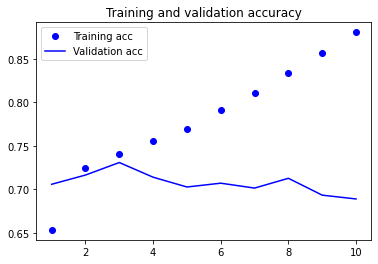

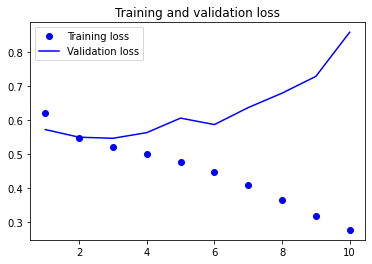

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

## Let's Reflect

### Experiment 1
We  trained the model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings
when lots of data is available. 

### Experiment 2
However, we used a pre-existing word-embedding. This is especially useful when we have a limited amount of training data.

### Experiment 3
Let's try a new approach. Suppose we loaded the GloVe pre-trained word embeddings but this time didn't freeeze the layer, meaning it would continue to refine the embeddings using our training data. How does that do?


# You try - Reuters Dataset 

This is the same dataset we used in the previous notebook. The dataset consists of text from the Reuters newswire in 1987. We will use a subset of the data that contain texts from eight topics:



Class | 	# train docs |	# test docs	| Total # docs
:--- | --: | --: | --:
acq |	1596	| 696	| 2292
crude | 	253 | 	121 |	374
earn	| 2840	| 1083	| 3923
grain	|41 | 	10 | 	51
interest | 	190	| 81	| 271
money-fx	| 206	| 87	| 293
ship	| 108	| 36	| 144
trade	| 251	| 75	| 326
Total	| 5485 |	2189	| 7674

The training dataset is http://zacharski.org/files/courses/cs419/r8-train-all-terms.txt

The test dataset is http://zacharski.org/files/courses/cs419/r8-test-all-terms.txt

Can you build a network that will classify texts into one of 8 categories?

Make predictions on the test set to see how well it performs.

Which is better

1. Computing our own embeddings
2. Using a pre-existing embeddings

In [27]:
!wget http://zacharski.org/files/courses/cs419/r8-train-all-terms.txt
!unzip r8-train-all-terms.txt

--2022-12-05 03:51:17--  http://zacharski.org/files/courses/cs419/r8-train-all-terms.txt
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3354435 (3.2M) [text/plain]
Saving to: ‘r8-train-all-terms.txt’

r8-train-all-terms. 100%[===================>]   3.20M  14.2MB/s    in 0.2s    

2022-12-05 03:51:17 (14.2 MB/s) - ‘r8-train-all-terms.txt’ saved [3354435/3354435]

Archive:  r8-train-all-terms.txt
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of r8-train-all-terms.txt or
        r8-train-all-terms.txt.zip, and cannot find r8-train-all-terms.txt.ZIP, period.


In [28]:
!wget http://zacharski.org/files/courses/cs419/r8-test-all-terms.txt
!unzip r8-train-all-terms.txt

--2022-12-05 03:51:18--  http://zacharski.org/files/courses/cs419/r8-test-all-terms.txt
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195272 (1.1M) [text/plain]
Saving to: ‘r8-test-all-terms.txt’

r8-test-all-terms.t 100%[===================>]   1.14M  5.83MB/s    in 0.2s    

2022-12-05 03:51:18 (5.83 MB/s) - ‘r8-test-all-terms.txt’ saved [1195272/1195272]

Archive:  r8-train-all-terms.txt
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of r8-train-all-terms.txt or
        r8-train-all-terms.txt.zip, and cannot find r8-train-all-terms.txt.ZIP, period.


In [29]:
import numpy as np
from keras.layers.core import Dense, Dropout, Flatten
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import layers
from keras.layers import Embedding
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras import models
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import preprocessing
from keras.datasets import reuters
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import pad_sequences
import matplotlib.pyplot as plt


In [30]:
max_features = 5000                                                              #
maxlen = 1000                                                                    
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features,
                                                         test_split=0.2)         
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
y_train = np_utils.to_categorical(y_train, 46)
y_test = np_utils.to_categorical(y_test, 46)                                     
word_index = reuters.get_word_index(path="reuters_word_index.json")              



550378/550378 [==============================] - 0s 0us/step


In [31]:
len(x_train) + len(x_test)
x_train[0]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [34]:
model = Sequential()                                                            # we'll begin by creating a easy exemplar utilizing 
model.add(Embedding(5000, 8, input_length=maxlen))                              # embedding We specify the greatest input size to our
model.add(Flatten())                                                            # Embedding layer afterwards the Embedding layer,
model.add(Dense(46, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=320,
                    validation_data=(x_test, y_test))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 8)           40000     
                                                                 
 flatten_3 (Flatten)         (None, 8000)              0         
                                                                 
 dense_4 (Dense)             (None, 46)                368046    
                                                                 
Total params: 408,046
Trainable params: 408,046
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
29/29 [==============================] - 3s 64ms/step - loss: 0.1442 - acc: 0.3299 - val_loss: 0.0716 - val_acc: 0.3620
Epoch 2/10
29/29 [==============================] - 2s 54ms/step - loss: 0.0690 - acc: 0.3706 - val_loss: 0.0678 - val_acc: 0.3638
Epoch 3/10
29/29 [==============================] 

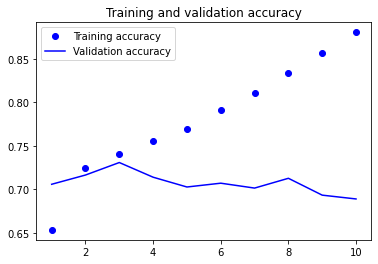

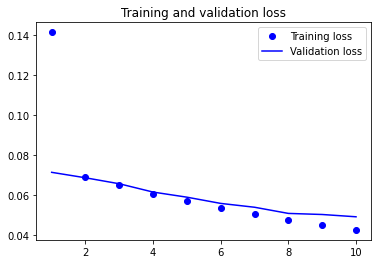

71/71 [==============================] - 1s 7ms/step - loss: 0.0492 - acc: 0.6006
Loss: 0.049
Accuracy: 0.601


In [33]:
accuray = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
scores = model.evaluate(x_test, y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

#### MIT License
Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.